# Data generator for Gerchberg-saxton Algorithm
## The optics based ML model will be simulated for comparison then tested empirically 

In [197]:
import matplotlib.pyplot as plt 
import numpy as np
import math 

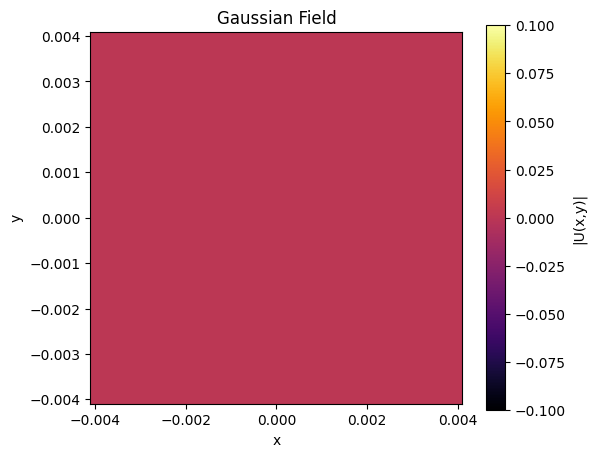

In [198]:
"""
Define spatial grid
"""

N = 2**10 # pixel resolution
dx = 8e-6 # pixel size
x = np.linspace(-N/2*dx, N/2*dx, N) # spatial axis
y = np.linspace(-N/2*dx, N/2*dx, N) # spatial axis
[X, Y] = np.meshgrid(x, y) # spatial grid
Rho = np.sqrt(X**2 + Y**2) # radial coordinate
Phi = np.arctan2(Y, X) # angular coordinate

"""
Define Gaussian field
"""

sigma = 5e-4   # width parameter (adjust to see effect)

U = np.exp(-(X**2 + Y**2) / sigma**2)

"""
Plot Gaussian field
"""

plt.figure(figsize=(6,5))
plt.imshow(np.angle(U), extent=[x.min(), x.max(), y.min(), y.max()], cmap="inferno")
plt.title("Gaussian Field")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="|U(x,y)|")
plt.show()



# Zernike polynomials

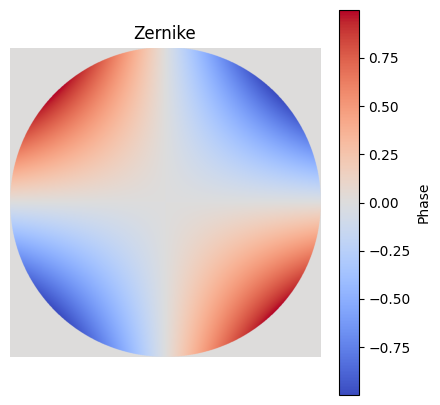

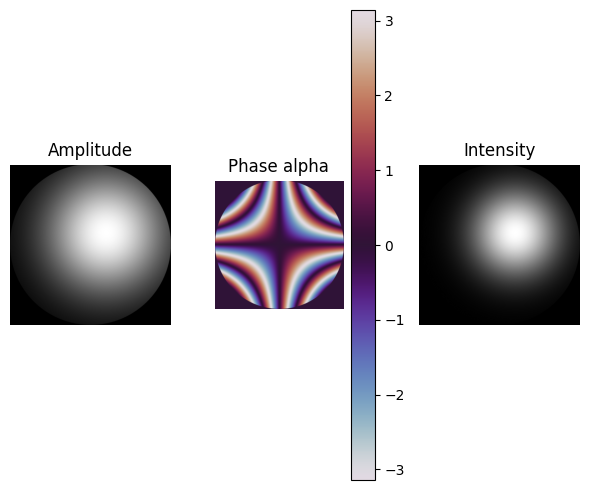

(-0.5, 1023.5, 1023.5, -0.5)

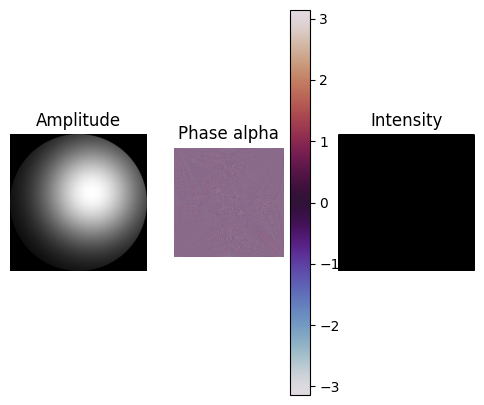

In [ ]:
"""
Define spatial grid
"""

N = 2**10 # pixel resolution
dx = 8e-6 # pixel size
x = np.linspace(-N/2*dx, N/2*dx, N) # spatial axis
y = np.linspace(-N/2*dx, N/2*dx, N) # spatial axis
[X, Y] = np.meshgrid(x, y) # spatial grid
Rho = np.sqrt(X**2 + Y**2) # radial coordinate
Phi = np.arctan2(Y, X) # angular coordinate

R_ap = (N/2) * dx       
rho = Rho / R_ap           
mask = rho <= 1

"""
Zernike function
"""
def R_nm(n, m, rho):
    R = np.zeros_like(rho)
    for k in range((n-m)//2+1):
        num = (-1)**k * math.factorial(n - k) / (math.factorial(k) * math.factorial((n + m)//2 - k) * math.factorial((n - m)//2 - k))
        R+= num * rho**(n - 2*k)
    return R
def Z_nm(n, m, rho, phi):
    Z = np.zeros_like(rho)
    if m>0:
        Z[mask] = R_nm(n, m, rho[mask]) * np.cos(m * phi[mask])
    elif m<0:
        Z[mask] = R_nm(n, -m, rho[mask]) * np.sin(-m * phi[mask])
    else:
        Z[mask] = R_nm(n, 0, rho[mask])
    return Z
"""
Define Gaussian field
"""

sigma = 3e-3   # width parameter 

U = np.exp(-(X**2 + Y**2) / sigma**2) # Gaussian field
U = np.exp(-((X)**2 + (Y)**2) / sigma**2)
Z = Z_nm(n=2, m=-2, rho=rho, phi=Phi) # Zernike phase
alpha = 4*np.pi
phase = alpha * Z 

U_complex = (U * mask) * np.exp(1j * phase) #


"""
Plot field
"""

plt.figure(figsize=(5,5))
plt.imshow(Z, cmap="coolwarm")
plt.colorbar(label="Phase")
plt.title("Zernike")
plt.axis("off")
plt.show()

plt.figure(figsize=(6,5))
plt.subplot(1,3,1)
plt.imshow(U*mask, cmap="gray")
plt.title("Amplitude")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(np.angle(U_complex), cmap="twilight")
plt.title("Phase alpha")
plt.axis("off")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.abs(U_complex)**2, cmap="gray")
plt.title("Intensity")
plt.axis("off")

plt.tight_layout()
plt.show()

A1 = np.abs(U_complex)
U2 = np.fft.fft2(U_complex)


A2 = np.abs(U2)

np.save("./Simulations/A1.npy", A1)
np.save("./Simulations/A2.npy", A2)

# eval
np.save("./Simulations/phi_true.npy", np.angle(U_complex))

plt.figure(figsize=(6,5))
plt.subplot(1,3,1)
plt.imshow(U*mask, cmap="gray")
plt.title("Amplitude")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(np.angle(U2), cmap="twilight")
plt.title("Phase alpha")
plt.axis("off")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.abs(U2)**2, cmap="gray")
plt.title("Intensity")
plt.axis("off")


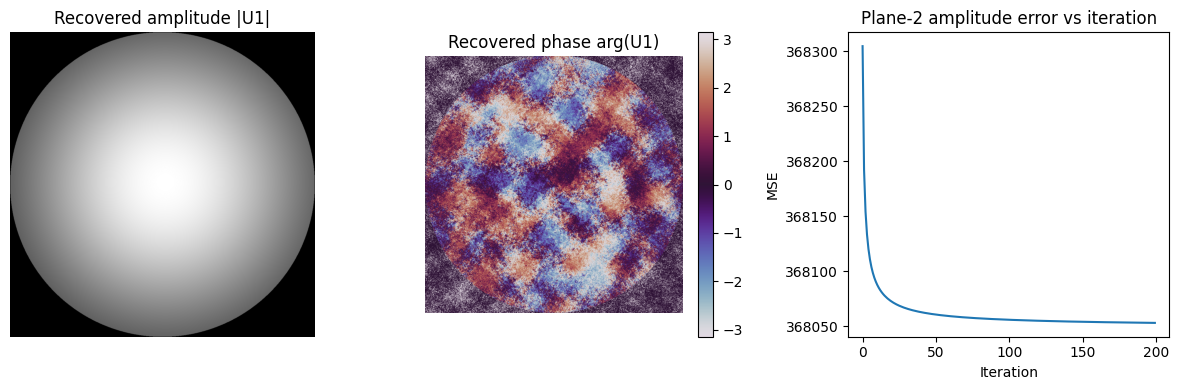

In [196]:
I1 = np.load("./Simulations/A1.npy")
I2 = np.load("./Simulations/A2.npy")
A1 = np.sqrt(I1)
A2 = np.sqrt(I2)


def gerchberg_saxton(A1, A2, n_iters=200, seed = 0, eps=1e-12):
    """
    Gerchberg-Saxton algorithm for phase retrieval.
    """
    # random intial phase in plane 1
    rng = np.random.default_rng(seed)
    phi0 = rng.uniform(-np.pi, np.pi, A1.shape)
    U1 = A1 * np.exp(1j * phi0)

    errors = []

    for i in range(n_iters):
        # propagate to plane 2
        U2 = np.fft.fft2(U1)
        # enforce amplitude constraint in plane 2
        U2 = A2 * np.exp(1j * np.angle(U2))
        # propagate back to plane 1
        U1 = np.fft.ifft2(U2)
        # enforce amplitude constraint in plane 1
        U1 = A1 * np.exp(1j * np.angle(U1))

        # compute error
        U2_check = np.fft.fft2(U1)
        error = np.mean((np.abs(U2_check) - A2)**2)
        errors.append(error)
    return U1, np.array(errors)

U1_est, errors = gerchberg_saxton(A1, A2, n_iters=200, seed=5)
phase_est = np.angle(U1_est)
amp_est = np.abs(U1_est)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(amp_est, cmap="gray")
plt.title("Recovered amplitude |U1|")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(phase_est, cmap="twilight")
plt.title("Recovered phase arg(U1)")
plt.axis("off")
plt.colorbar()

plt.subplot(1,3,3)
plt.plot(errors)
plt.title("Plane-2 amplitude error vs iteration")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()